In [1]:
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import math


class TreeNode:
    def __init__(self, feature=None, amountThr=None,g=None, Entropy=None, Left=None, Right=None,leafVal=None):
        self.feature = feature
        self.amountThr = amountThr
        self.Left = Left
        self.Right = Right
        self.leafVal = leafVal
        self.gain = g
        self.Entropy = Entropy
    def IsLeaf(self):
        return self.leafVal is not None


class DecisionTree:
    def __init__(self, MaxDepth=100, featureCount=None):
        self.MaxDepth=MaxDepth
        self.featureCount=featureCount
        self.root=None

    def fitRoot(self, X, y):
        if self.featureCount == None:
            self.featureCount = X.shape[1]
        else:
            self.featureCount = min(X.shape[1],self.featureCount)
        self.root = self.ExpandTree(X, y)

    def ExpandTree(self, X, y, depth=0):
        sampleCount = X.shape[0]
        featureCount = X.shape[1]
        LableCount = len(np.unique(y))

        if (depth>=self.MaxDepth or LableCount==1 or sampleCount<2):
            c = Counter(y)
            leaf_Val = c.most_common(2)[0][0]
            return TreeNode(leafVal=leaf_Val)

        best_feature, best_thresh, Bestgain, best_entp = self.SplitWithBest(X, y, featureCount)
        # create childs
        leftIdxs, rightIdxs = self.Splitnode(X[:, best_feature], best_thresh)
        Left = self.ExpandTree(X[leftIdxs, :], y[leftIdxs], depth+1)
        Right = self.ExpandTree(X[rightIdxs, :], y[rightIdxs], depth+1)
        return TreeNode(best_feature, best_thresh,Bestgain, best_entp, Left, Right)

    def MyEntropy(self, y):
        ps = np.bincount(y)/ len(y) #[0's count, 1's count]
        array = []
        for p in ps:
            if p>0:
                array.append(p * np.log(p))
        result_Entp = -1 * np.sum(array)
        if np.sum(array) == 0:
            return 0
        return result_Entp

    def SplitWithBest(self, X, y, feat_idxs):
        Bestgain = -1
        split_idx = None
        split_threshold = None
        for feat_idx in range(feat_idxs):
            X_column = X[:, feat_idx]
            amountThrs = np.unique(X_column)
            for thr in amountThrs:
                tmp = self.InformationGain(y, X_column, thr)
                if tmp != 0:
                    gain = tmp[0]
                    entp = tmp[1]
                else:
                    gain = 0
                    entp = 0
                if gain > Bestgain:
                    Bestgain = gain
                    best_entp = entp
                    split_idx = feat_idx
                    split_threshold = thr
        return split_idx, split_threshold, Bestgain, best_entp

    def Splitnode(self, X_column, s_amountThrsh):
        l_idx = np.argwhere(X_column <= s_amountThrsh)
        IDXLeft = l_idx.flatten()
        r_idx = np.argwhere(X_column > s_amountThrsh)
        IDXRight = r_idx.flatten()
        return IDXLeft, IDXRight

    def InformationGain(self, y, X_column, amountThr):
        EntropyParent = self.MyEntropy(y)
        leftIdxs, rightIdxs = self.Splitnode(X_column, amountThr)
        if len(leftIdxs) == 0 or len(rightIdxs) == 0:
            return 0
        # weighted avgerage entropy of childs
        y_count = len(y)
        left_count = len(leftIdxs)
        right_count = len(rightIdxs)
        left_entp = self.MyEntropy(y[leftIdxs])
        right_entp = self.MyEntropy(y[rightIdxs])
        childEntropy = (left_count/y_count)*left_entp + (right_count/y_count)*right_entp

        information_gain = EntropyParent - childEntropy
        arr = []
        arr.append(information_gain)
        arr.append(childEntropy)
        return arr

    def TreeTraverse(self, x, node):
        if node.IsLeaf():
            return node.leafVal
        if x[node.feature] <= node.amountThr:
            return self.TreeTraverse(x, node.Left)
        return self.TreeTraverse(x, node.Right)

def Find_DecisionTree (node):
    if node == None:
        return
    if node.IsLeaf():
        print("- leaf\t" , node.leafVal)
    else:
        print("- feat\t" ,node.feature , "  - thresh\t" , node.amountThr, "  - information gain\t", node.gain, "  - entropy\t", node.Entropy)
    Find_DecisionTree(node.Left)
    Find_DecisionTree(node.Right)

dataset = pd.read_csv(".\diabetes.csv")

datelen = len(dataset.columns)-1
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:, datelen].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0 #1234
)

clf = DecisionTree(MaxDepth=50)
clf.fitRoot(X_train, y_train)

#test X_test
ResArray = []
for xx in X_test:
    res = clf.TreeTraverse(xx, clf.root)
    ResArray.append(res)
Result = np.array(ResArray)

#calculate right answers (deghat)
deghat = np.sum(y_test == Result) / len(y_test)
print("deghat(accuracy): ", deghat)

Find_DecisionTree(clf.root)

deghat(accuracy):  0.7337662337662337
- feat	 1   - thresh	 123.0   - information gain	 0.09117258495016212   - entropy	 0.5622081176268778
- feat	 5   - thresh	 26.4   - information gain	 0.05441080933782194   - entropy	 0.423974433117583
- feat	 6   - thresh	 0.673   - information gain	 0.017602822069490306   - entropy	 0.03981510096057002
- leaf	 0
- feat	 6   - thresh	 0.678   - information gain	 0.2145591551764051   - entropy	 0.0
- leaf	 1
- leaf	 0
- feat	 7   - thresh	 28.0   - information gain	 0.04652942788478431   - entropy	 0.516880226717072
- feat	 5   - thresh	 30.9   - information gain	 0.027899187083508248   - entropy	 0.3524855589846186
- feat	 0   - thresh	 6.0   - information gain	 0.11251593411963928   - entropy	 0.0
- leaf	 0
- leaf	 1
- feat	 2   - thresh	 52.0   - information gain	 0.04276238997726162   - entropy	 0.4192745194891954
- feat	 6   - thresh	 0.496   - information gain	 0.6365141682948128   - entropy	 0.0
- leaf	 1
- leaf	 0
- feat	 6   - thresh	 0.49

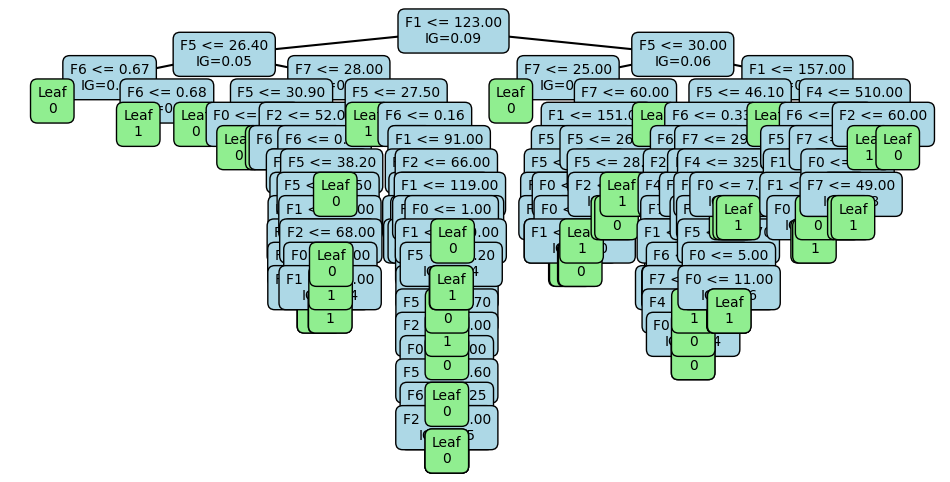

In [2]:
import matplotlib.pyplot as plt

def plot_tree(node, depth=0, pos=0, parent_pos=None, ax=None, spacing=1.5):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_axis_off()
    
    x = pos
    y = -depth * spacing

    if parent_pos is not None:
        ax.plot([parent_pos, x], [-(depth-1)*spacing, y], 'k-')

    if node.IsLeaf():
        ax.text(x, y, f'Leaf\n{node.leafVal}', ha='center', va='center',
                bbox=dict(facecolor='lightgreen', boxstyle='round,pad=0.5'))
    else:
        ax.text(x, y, f'F{node.feature} <= {node.amountThr:.2f}\nIG={node.gain:.2f}', 
                ha='center', va='center',
                bbox=dict(facecolor='lightblue', boxstyle='round,pad=0.5'))
        # Calculate positions for child nodes
        left_pos = x - 2**(-depth)
        right_pos = x + 2**(-depth)
        plot_tree(node.Left, depth+1, left_pos, x, ax)
        plot_tree(node.Right, depth+1, right_pos, x, ax)
    
    if parent_pos is None:
        plt.show()

plot_tree(clf.root)

In [32]:
!pip install graphviz

In [7]:
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
import math

# Decision Tree Node
class TreeNode:
    def __init__(self, feature=None, amountThr=None, g=None, Entropy=None, Left=None, Right=None, leafVal=None):
        self.feature = feature
        self.amountThr = amountThr
        self.Left = Left
        self.Right = Right
        self.leafVal = leafVal
        self.gain = g
        self.Entropy = Entropy

    def IsLeaf(self):
        return self.leafVal is not None


class DecisionTree:
    def __init__(self, MaxDepth=100, featureCount=None):
        self.MaxDepth = MaxDepth
        self.featureCount = featureCount
        self.root = None

    def fitRoot(self, X, y):
        if self.featureCount is None:
            self.featureCount = X.shape[1]
        else:
            self.featureCount = min(X.shape[1], self.featureCount)
        self.root = self.ExpandTree(X, y)

    def ExpandTree(self, X, y, depth=0):
        sampleCount = X.shape[0]
        featureCount = X.shape[1]
        LableCount = len(np.unique(y))

        # stop conditions
        if (depth >= self.MaxDepth or LableCount == 1 or sampleCount < 2):
            if len(y) == 0:
                return None
            c = Counter(y)
            leaf_Val = c.most_common(1)[0][0]
            return TreeNode(leafVal=leaf_Val)

        best_feature, best_thresh, Bestgain, best_entp = self.SplitWithBest(X, y, featureCount)

        # if no valid split
        if best_feature is None:
            c = Counter(y)
            leaf_Val = c.most_common(1)[0][0]
            return TreeNode(leafVal=leaf_Val)

        # split data
        leftIdxs, rightIdxs = self.Splitnode(X[:, best_feature], best_thresh)

        # if one side is empty, stop splitting
        if len(leftIdxs) == 0 or len(rightIdxs) == 0:
            c = Counter(y)
            leaf_Val = c.most_common(1)[0][0]
            return TreeNode(leafVal=leaf_Val)

        # otherwise, continue expanding
        Left = self.ExpandTree(X[leftIdxs, :], y[leftIdxs], depth + 1)
        Right = self.ExpandTree(X[rightIdxs, :], y[rightIdxs], depth + 1)
        return TreeNode(best_feature, best_thresh, Bestgain, best_entp, Left, Right)

    def MyEntropy(self, y):
        ps = np.bincount(y) / len(y)
        array = []
        for p in ps:
            if p > 0:
                array.append(p * np.log(p))
        result_Entp = -1 * np.sum(array)
        if np.sum(array) == 0:
            return 0
        return result_Entp

    def SplitWithBest(self, X, y, feat_idxs):
        Bestgain = -1
        split_idx = None
        split_threshold = None
        best_entp = None
        for feat_idx in range(feat_idxs):
            X_column = X[:, feat_idx]
            amountThrs = np.unique(X_column)
            for thr in amountThrs:
                tmp = self.InformationGain(y, X_column, thr)
                if tmp != 0:
                    gain = tmp[0]
                    entp = tmp[1]
                else:
                    gain = 0
                    entp = 0
                if gain > Bestgain:
                    Bestgain = gain
                    best_entp = entp
                    split_idx = feat_idx
                    split_threshold = thr
        return split_idx, split_threshold, Bestgain, best_entp

    def Splitnode(self, X_column, s_amountThrsh):
        l_idx = np.argwhere(X_column <= s_amountThrsh)
        IDXLeft = l_idx.flatten()
        r_idx = np.argwhere(X_column > s_amountThrsh)
        IDXRight = r_idx.flatten()
        return IDXLeft, IDXRight

    def InformationGain(self, y, X_column, amountThr):
        EntropyParent = self.MyEntropy(y)
        leftIdxs, rightIdxs = self.Splitnode(X_column, amountThr)
        if len(leftIdxs) == 0 or len(rightIdxs) == 0:
            return 0
        y_count = len(y)
        left_count = len(leftIdxs)
        right_count = len(rightIdxs)
        left_entp = self.MyEntropy(y[leftIdxs])
        right_entp = self.MyEntropy(y[rightIdxs])
        childEntropy = (left_count / y_count) * left_entp + (right_count / y_count) * right_entp
        information_gain = EntropyParent - childEntropy
        return [information_gain, childEntropy]

    def TreeTraverse(self, x, node):
        if node is None:
            return 0
        if node.IsLeaf():
            return node.leafVal
        if x[node.feature] <= node.amountThr:
            return self.TreeTraverse(x, node.Left)
        return self.TreeTraverse(x, node.Right)


# Helper to print tree
def Find_DecisionTree(node, depth=0):
    prefix = "  " * depth
    if node is None:
        return
    if node.IsLeaf():
        print(f"{prefix}- Leaf: {node.leafVal}")
    else:
        print(f"{prefix}- Feature {node.feature} | Threshold {node.amountThr:.4f} | Gain {node.gain:.4f}")
        Find_DecisionTree(node.Left, depth + 1)
        Find_DecisionTree(node.Right, depth + 1)

dataset = pd.read_csv("titanicspl.csv")

# Drop irrelevant text columns
dataset = dataset.drop(["name", "ticket", "cabin"], axis=1)

# Fill missing values
dataset["age"] = dataset["age"].fillna(dataset["age"].median())
dataset["fare"] = dataset["fare"].fillna(dataset["fare"].median())
dataset["embarked"] = dataset["embarked"].fillna(dataset["embarked"].mode()[0])

# Encode categorical variables
dataset = pd.get_dummies(dataset, drop_first=True)

# Split into features and target
X = dataset.drop("survived", axis=1).values
y = dataset["survived"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train & Evaluate Tree
clf = DecisionTree(MaxDepth=10)
clf.fitRoot(X_train, y_train)

ResArray = [clf.TreeTraverse(xx, clf.root) for xx in X_test]
Result = np.array(ResArray)
accuracy = np.sum(y_test == Result) / len(y_test)
print(f"\nAccuracy on Titanic test set: {accuracy:.4f}\n")
print("Decision Tree Structure:")
Find_DecisionTree(clf.root)



Accuracy on Titanic test set: 0.7824

Decision Tree Structure:
- Feature 5 | Threshold 0.0000 | Gain 0.1443
  - Feature 0 | Threshold 2.0000 | Gain 0.1341
    - Feature 4 | Threshold 31.6792 | Gain 0.0225
      - Feature 1 | Threshold 21.0000 | Gain 0.0310
        - Leaf: 1
        - Feature 4 | Threshold 31.0000 | Gain 0.0254
          - Feature 1 | Threshold 55.0000 | Gain 0.0198
            - Feature 4 | Threshold 12.6500 | Gain 0.0209
              - Leaf: 1
              - Feature 1 | Threshold 22.0000 | Gain 0.0330
                - Leaf: 0
                - Feature 1 | Threshold 29.0000 | Gain 0.0191
                  - Feature 7 | Threshold 0.0000 | Gain 0.0678
                    - Leaf: 1
                    - Leaf: 1
                  - Feature 1 | Threshold 36.0000 | Gain 0.0662
                    - Leaf: 1
                    - Leaf: 1
            - Feature 0 | Threshold 1.0000 | Gain 0.6931
              - Leaf: 1
              - Leaf: 0
          - Leaf: 0
      - Feat

In [10]:
from sklearn.tree import DecisionTreeClassifier
clf2 = DecisionTreeClassifier(max_depth=5)
clf2.fit(X_train, y_train)
print("Sklearn accuracy:", clf2.score(X_test, y_test))

Sklearn accuracy: 0.8015267175572519


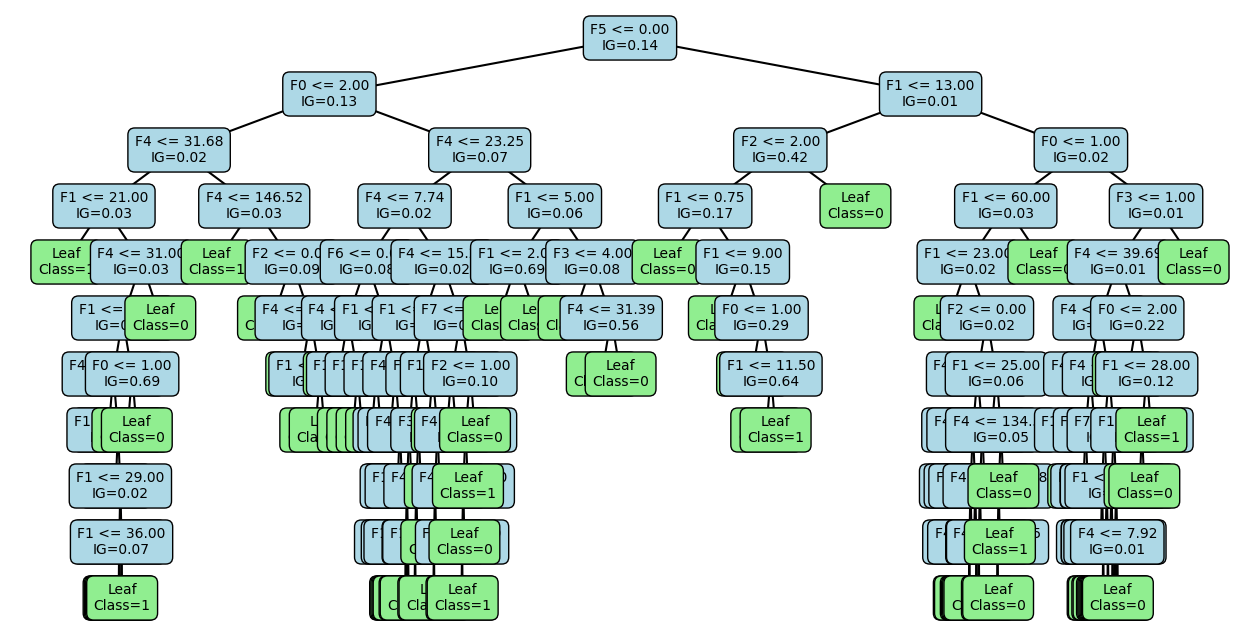

In [8]:
import matplotlib.pyplot as plt

def plot_tree_matplotlib(node, depth=0, x=0.5, dx=0.25, parent=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_axis_off()

    y = -depth  # vertical position

    # Node label
    if node is None:
        return
    if node.IsLeaf():
        label = f"Leaf\nClass={node.leafVal}"
        color = "lightgreen"
    else:
        label = f"F{node.feature} <= {node.amountThr:.2f}\nIG={node.gain:.2f}"
        color = "lightblue"

    # Draw node
    ax.text(x, y, label, ha='center', va='center', fontsize=10,
            bbox=dict(facecolor=color, boxstyle="round,pad=0.5"))

    # Draw edge from parent
    if parent is not None:
        ax.plot([parent[0], x], [parent[1], y], 'k-')

    # Recurse for children
    if not node.IsLeaf():
        plot_tree_matplotlib(node.Left, depth + 1, x - dx, dx / 2, (x, y), ax)
        plot_tree_matplotlib(node.Right, depth + 1, x + dx, dx / 2, (x, y), ax)

    if depth == 0:
        plt.show()

# Plot the trained Titanic decision tree
plot_tree_matplotlib(clf.root)